In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Flatten,Dense,Conv2D,MaxPooling2D,UpSampling2D,Reshape,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report

In [3]:
data_dir = "/content/drive/MyDrive/chest_xray"
num_classes = 3
image_size = (128,128)
batch_size = 32
validation_split = 0.2
epochs = 50

In [4]:
def load_data(data_dir, image_size, batch_size, validation_split):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

    train_data_classifier = datagen.flow_from_directory(
        os.path.join(data_dir, "train"),
        target_size=image_size,
        color_mode="grayscale",
        class_mode="binary",
        batch_size=batch_size,
        subset="training",
        shuffle=True
    )

    val_data_classifier = datagen.flow_from_directory(
        os.path.join(data_dir, "train"),
        target_size=image_size,
        color_mode="grayscale",
        class_mode="binary",
        batch_size=batch_size,
        subset="validation",
        shuffle=False
    )

    test_data_classifier = datagen.flow_from_directory(
        os.path.join(data_dir, "test"),
        target_size=image_size,
        color_mode="grayscale",
        class_mode="binary",
        batch_size=batch_size,
        shuffle=False
    )

    return (
        train_data_classifier,
        val_data_classifier,
        test_data_classifier
    )

In [5]:
def display_results(original,reconstructed):
    plt.figure(figsize=(10,6))
    n = 10
    for i in range(n):
        # Original Images
        ax = plt.subplot(2,10,i+1)
        plt.imshow(original[1].reshape(128,128))
        plt.title("Original")
        plt.axis("off")
        # Reconstructed Images
        ax = plt.subplot(2,10,i+1+n)
        plt.imshow(reconstructed[i].reshape(128,128))
        plt.title("ReConctsructed")
        plt.axis("off")
    plt.show()

In [6]:
def plot_metrics(history,title):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.grid(True)
    plt.title(f"{title}-Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='validation Accuracy')
    plt.grid(True)
    plt.title(f"{title}-Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [7]:
def build_classifier(input_shape,num_classes=2):
    classifier_input = Input(shape=input_shape)

    x = Conv2D(32,(5,5),activation='relu',padding='same')(classifier_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2),padding='same')(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64,(5,5),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2),padding='same')(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128,(5,5),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2),padding='same')(x)
    x = Dropout(0.2)(x)

    x = Conv2D(256,(5,5),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2),padding='same')(x)
    x = Flatten()(x)

    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(1,activation='sigmoid')(x)

    classifier = Model(classifier_input,output)
    classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return classifier

In [8]:
def train_classifier(classifier,train_data,val_data,callbacks,epochs):
    history = classifier.fit(train_data,epochs=epochs,validation_data=val_data,callbacks=callbacks)
    return history

In [9]:
def evaluate_classifier(classifier,test_data):
    y_pred = classifier.predict(test_data)
    y_pred_classes = np.argmax(y_pred,axis=1)
    y_true_classes = test_data.classes
    # Classification Report
    print("Classification Report:\n")
    print(classification_report(y_true_classes,y_pred_classes))
    # Confusion Matrix
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_true_classes,y_pred_classes)
    sns.heatmap(cm,annot=True,fmt=".2f",cmap="Blues")
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    # Displaying Results
    X_test, _ = next(test_data)
    for i in range(10):
        plt.imshow(X_test[i].reshape(128, 128))
        plt.title(f"Predicted: {y_pred_classes[i]}, Actual: {y_true_classes[i]}")
        plt.axis("off")
        plt.show()

In [10]:
def display_classifier_results(images, y_true, y_pred, num_samples=5):

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 4))

    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"True: {y_true[i]}\nPred: {y_pred[i]}", fontsize=10)

    plt.show()

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8514 - loss: 0.3464

131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 577ms/step - accuracy: 0.8519 - loss: 0.3455 - val_accuracy: 0.7430 - val_loss: 2.2075 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9528 - loss: 0.1284

131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 434ms/step - accuracy: 0.9529 - loss: 0.1283 - val_accuracy: 0.7430 - val_loss: 1.4951 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9697 - loss: 0.0860

131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 430ms/step - accuracy: 0.9697 - loss: 0.0860 - val_accuracy: 0.7440 - val_loss: 1.0670 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 436ms/step - accuracy: 0.9723 - loss: 0.0767 - val_accuracy: 0.7430 - val_loss: 1.8605 - learning_rate: 0.0010
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 430ms/step - accuracy: 0.9691 - loss: 0.0820 - val_accuracy: 0.7430 - val_loss: 4.2851 - learning_rate: 0.0010
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9812 - loss: 0.0593

131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 427ms/step - accuracy: 0.9811 - loss: 0.0593 - val_accuracy: 0.9530 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 425ms/step - accuracy: 0.9855 - loss: 0.0469 - val_accuracy: 0.7900 - val_loss: 0.9002 - learning_rate: 0.0010
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 419ms/step - accuracy: 0.9810 - loss: 0.0484 - val_accuracy: 0.5733 - val_loss: 2.1526 - learning_rate: 0.0010
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9842 - loss: 0.0468 - val_accuracy: 0.8763 - val_loss: 0.4088 - learning_rate: 0.0010
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 420ms/step - accuracy: 0.9862 - loss: 0.0490 - val_accuracy: 0.8245 - val_loss: 0.6096 - learning_rate: 5.0000e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9924 - loss: 0.0187

131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 420ms/step - accuracy: 0.9924 - loss: 0.0187 - val_accuracy: 0.9636 - val_loss: 0.0990 - learning_rate: 5.0000e-04
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.9920 - loss: 0.0235 - val_accuracy: 0.9655 - val_loss: 0.1152 - learning_rate: 5.0000e-04
Epoch 13/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 416ms/step - accuracy: 0.9980 - loss: 0.0093 - val_accuracy: 0.7469 - val_loss: 1.4015 - learning_rate: 5.0000e-04
Epoch 14/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 419ms/step - accuracy: 0.9936 - loss: 0.0181 - val_accuracy: 0.9156 - val_loss: 0.2182 - learning_rate: 5.0000e-04
Epoch 15/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9979 - loss: 0.0087

131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.9979 - loss: 0.0087 - val_accuracy: 0.9799 - val_loss: 0.0517 - learning_rate: 2.5000e-04
Epoch 16/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 54s 413ms/step - accuracy: 0.9985 - loss: 0.0061 - val_accuracy: 0.9779 - val_loss: 0.0610 - learning_rate: 2.5000e-04
Epoch 17/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9987 - loss: 0.0074

131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 432ms/step - accuracy: 0.9987 - loss: 0.0074 - val_accuracy: 0.9856 - val_loss: 0.0437 - learning_rate: 2.5000e-04
Epoch 18/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 420ms/step - accuracy: 0.9998 - loss: 0.0030 - val_accuracy: 0.9827 - val_loss: 0.0491 - learning_rate: 2.5000e-04
Epoch 19/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 418ms/step - accuracy: 0.9996 - loss: 0.0031 - val_accuracy: 0.9847 - val_loss: 0.0442 - learning_rate: 2.5000e-04
Epoch 20/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 419ms/step - accuracy: 0.9994 - loss: 0.0038 - val_accuracy: 0.9847 - val_loss: 0.0560 - learning_rate: 2.5000e-04
Epoch 21/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 429ms/step - accuracy: 0.9998 - loss: 0.0027 - val_accuracy: 0.9837 - val_loss: 0.0530 - learning_rate: 1.2500e-04
Epoch 22/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 407ms/step - accuracy: 0.9997 - loss: 0.0026 - val_accuracy: 0.9856 - val_loss: 0.0497 - learning_rate: 1.2500e-04


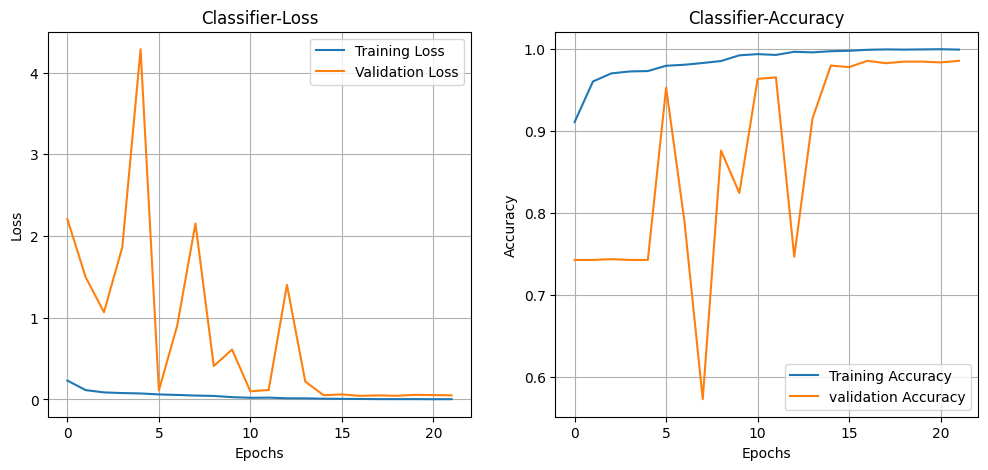

20/20 ━━━━━━━━━━━━━━━━━━━━ 394s 21s/step - accuracy: 0.5177 - loss: 2.4551
Classifier Test Loss: 1.4223
Classifier Test Accuracy: 73.5577%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


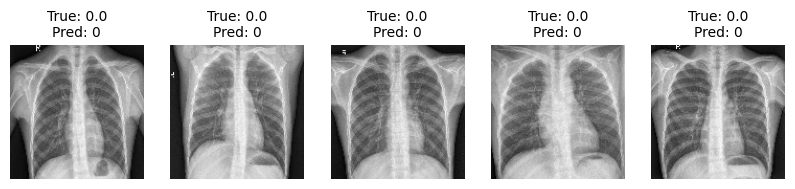

In [11]:
def main():
    # Load data
    (train_data_classifier, val_data_classifier, test_data_classifier) = load_data(
        data_dir, image_size, batch_size, validation_split
    )

    classifier = build_classifier((128, 128, 1), num_classes)
    classifier_callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=3),
        ModelCheckpoint("best_classifier_xray.h5", save_best_only=True)
    ]
    classifier_history = train_classifier(classifier, train_data_classifier, val_data_classifier, classifier_callbacks, epochs)

    plot_metrics(classifier_history, "Classifier")

    test_loss, test_accuracy = classifier.evaluate(test_data_classifier)
    print(f"Classifier Test Loss: {test_loss:.4f}")
    print(f"Classifier Test Accuracy: {test_accuracy:.4%}")

    x_test_sample, y_test_sample = next(iter(test_data_classifier))
    y_pred_probs = classifier.predict(x_test_sample)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = y_test_sample

    display_classifier_results(x_test_sample, y_true, y_pred, num_samples=5)

if __name__ == '__main__':
    main()